# Planet Terror

Jack Carter - 26/08/2022

## Summary

This project uses a refined version of the terorrism risk headlines obtained in the author's 'Risky Business' project to determine whether neural networks can perform classification tasks well on small data sets. Despite having only 128 terror event headlines, the models used here achieve an accuracy of over 90%. 

## 1) Preparation

### Import libraries & set options

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

### Read in the terror events data frame

The terror events data frame contains terror event, falseflag other violence and random headlines. 
Falseflag headlines contain terrorism related words but do not constitute a terror event, while the other violence risk headlines include military conflict, social unrest and organized crime related news. 

In [2]:
# creates a risks data set with terrorism and non-terrorism headlines. 
terror_events = pd.read_csv('C:/Users/HUAWEI/Desktop/Projects/Planet-Terror/Data/terror_events.csv', encoding = 'ISO-8859-1')

# view sample headlines:
terror_events.head(4)

,Headline,Category
0,"Al-Shabab terrorist attack at Somali hotel kills 20, injures 40",terrorism
1,Several killed in suspected ISIL attack on northeast Syria iftar,terrorism
2,Five Dead in Attack by Suspected FARC Dissidents in Colombia,terrorism
3,Terrorist attacks in Mali leave 66 dead,terrorism


### Read in the random data frame

The random data frame contains a variety of headlines from online papers across the world which did not score anything in terms of violence risks on the author's previous 'Risky Business' project. 

In [3]:
# creates a random data set. 
# these random headlines give the algorithm a clear idea of what isn't terrorism. 
random_data = pd.read_csv('C:/Users/HUAWEI/Desktop/Projects/Planet-Terror/Data/random_headlines.csv', encoding = 'ISO-8859-1')
random_df = random_data.sample(50)
random_df.iloc[:,0:2].head(4)

,Headline,Category
177,Customs reported that the services were resumed after infrastructure problems; Ecuapass is partially enabled,random
455,"1 confirmed monkeypox case transited through S'pore to Australia, 13 persons put on phone surveillance: MOH",random
244,The tennis star and the virus,random
77,Handicraft / COVID-19: profit tax made in 2020 will be paid in five equal instalments,random


### Combine the data

The data is combined to create a single data frame.

In [4]:
# creates a combined data frame, drops duplicates and checks how many of each headlines type.
combined_data = pd.concat([terror_events, random_df.iloc[:,0:2]]).reset_index()
unique = combined_data.loc[:,'Headline'].drop_duplicates().index
df = combined_data.iloc[unique,:]
df.Category.value_counts()

falseflag            176
terrorism            127
military_conflict     84
social_unrest         66
organized_crime       61
random                50
Name: Category, dtype: int64

### Headlines by category

This cell visualizes the headlines by category.

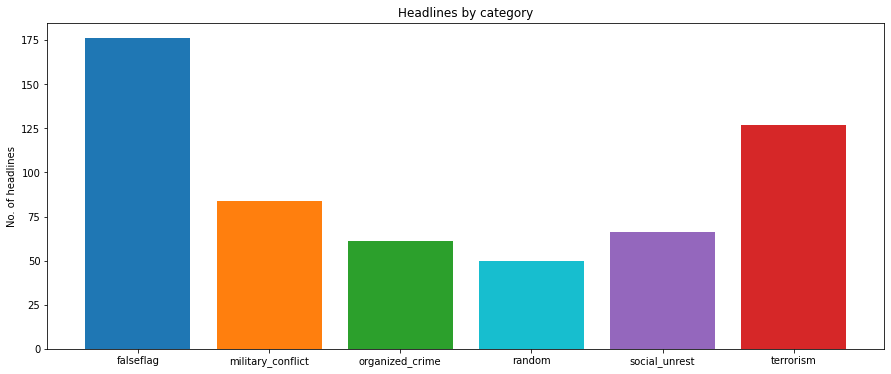

In [5]:
# visualizes how many of each category there are. 
import matplotlib.pyplot as plt

count = df.groupby(df.loc[:,'Category']).size().reset_index(name='counts') 

fig = plt.figure(figsize=(15,6)) 
plt.bar(count.loc[:,'Category'], count.loc[:,'counts'], color=['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:purple', 'tab:red'], width = 0.8)
plt.ylabel("No. of headlines")
plt.title("Headlines by category")
plt.show()

### Re-assign labels

The headline labels are re-assigned to either 'terrorism' or 'none'.

In [6]:
# checks how many terrorism vs non-terrorism headlines we have.
target = 'terrorism'
df.loc[df['Category'] != target, 'Category'] = 'none'
df.Category.value_counts()

none         437
terrorism    127
Name: Category, dtype: int64

This cell checks the ratio of terror to non-terror headlines.

In [7]:
# checks the percentage of terrorism vs non-terrorism headlines. 
non_terror = len(df.loc[df['Category'] != target, 'Category'])
terror = len(df.loc[df['Category'] == target, 'Category'])

print('The ratio of terror headlines is: ' + str(round((terror/non_terror)*100)) + '%')

The ratio of terror headlines is: 29%


### Terror vs non-terror headlines

This cell visualizes the proportion of terror to non-terror headlines in our data frame.

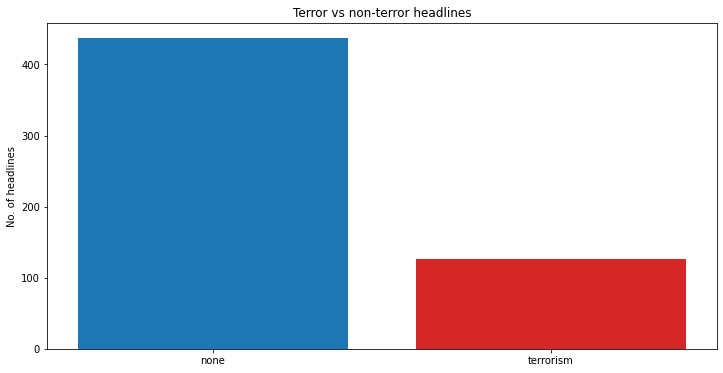

In [8]:
# visualizes how many terror vs non-terror headlines there are.
count = df.groupby(df.loc[:,'Category']).size().reset_index(name='counts')

fig = plt.figure(figsize=(12,6)) 
plt.bar(count.loc[:,'Category'], count.loc[:,'counts'], color=['tab:blue', 'tab:red'], width = 0.8)
plt.ylabel("No. of headlines")
plt.title("Terror vs non-terror headlines")
plt.show()

### Split into training and test sets

The data is split into a training (80%) and test (20%) set.

In [9]:
# splits the data into train and test sets and prints the percentage of headlines in each data set. 
x = df['Headline']
y = np.where(df['Category'] == target, 1, 0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2007)

for dataset in [x_train, x_test]:
    print('Dataset has {}{} of the data.'.format((round(len(dataset) / len(df['Headline']), 2))*100, '%'))

Dataset has 80.0% of the data.
Dataset has 20.0% of the data.


### Convert headlines to sequences

The headlines are converted to sequences where each unique word has its own number.

In [10]:
# 'fit_on_texts' assigns a unique number for each word in our vocab.
# 'texts_to_sequences' replaces each headline with a number sequence. 
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# views a sample sequence:
x_train_seq[0]

[91, 107, 17, 161, 218, 162, 163]

### View sequences

This cell visualizes the sequences with a scatterplot.

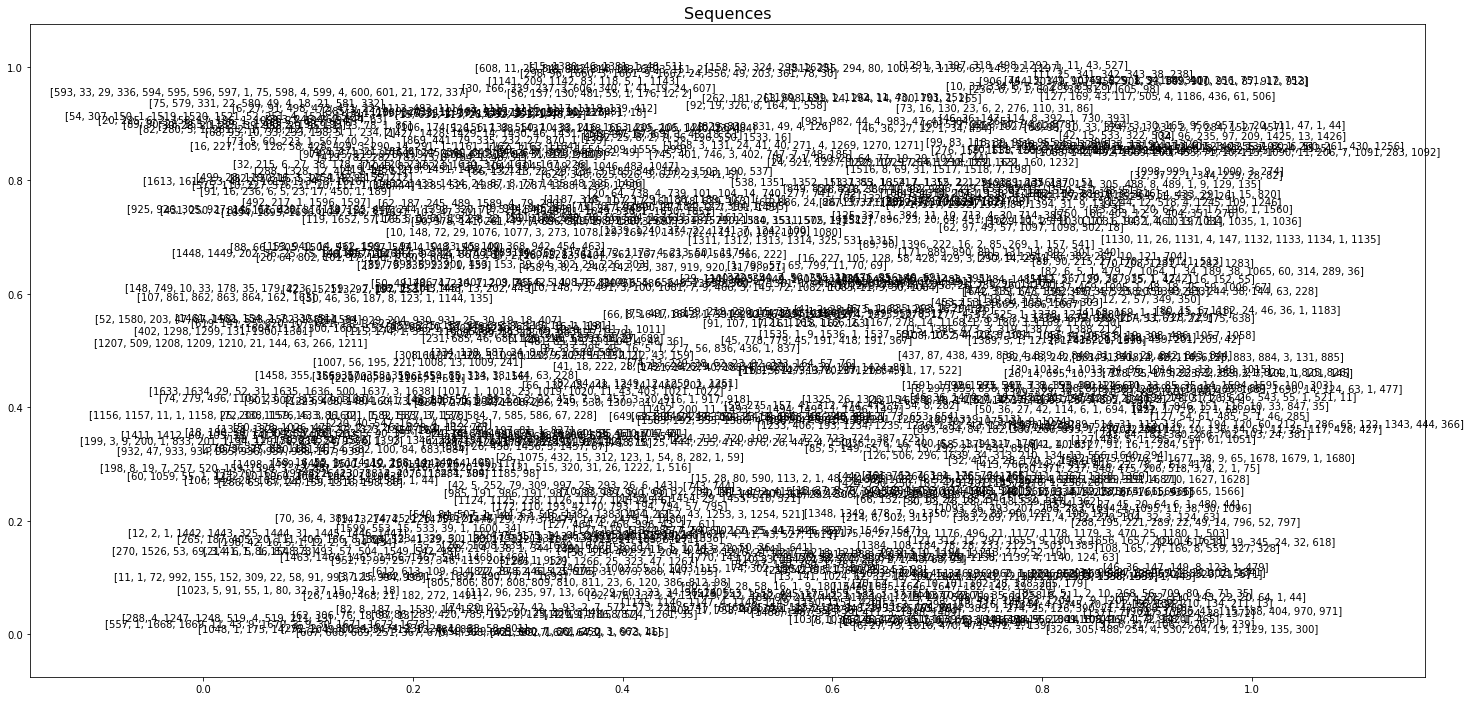

In [11]:
# creates a scatterplot of the text sequences. 
x = np.random.random(len(x_train_seq))
y = np.random.random(len(x_train_seq))
txt = x_train_seq

fig, axes = plt.subplots(figsize=(25,12))
axes.scatter(x, y, s=0.01)
axes.set_xlim(-0.165, 1.165)
axes.set_ylim(-0.075, 1.075)
for i, txt in enumerate(txt):
    axes.annotate(text=txt, xy=(x[i], y[i]), ha='center')
plt.title('Sequences', size=16)
plt.show()

### Sequence word counts

The visualization below shows how the sequences are comprised of varying word lengths, with most having around 10 words. 

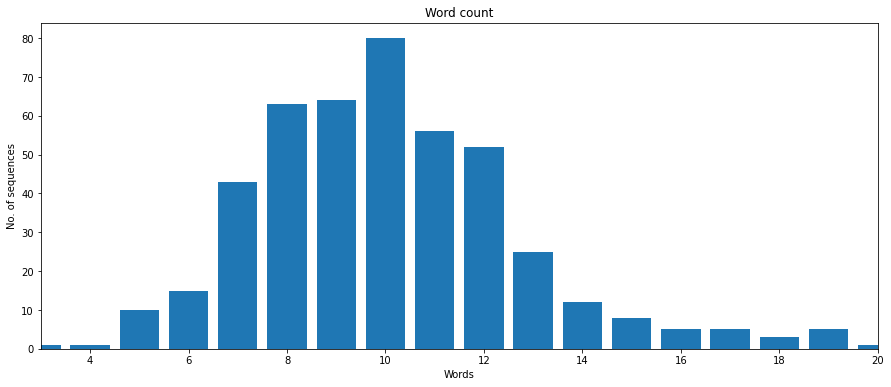

In [12]:
# creates a barplot of the sequence word counts. 
from collections import Counter

lengths = []

for i in range(len(x_train_seq)):
    lengths.append(len(x_train_seq[i]))
    
words_df = pd.DataFrame()
words_df['words'] = list(Counter(lengths).keys())
words_df['frequency'] = list(Counter(lengths).values())
words_df.sort_values('words')

fig, axes = plt.subplots(figsize=(15,6))
axes.bar(list(words_df['words']), list(words_df['frequency']))

plt.xlabel('Words')
plt.ylabel('No. of sequences')
plt.xlim(3,20)
plt.title('Word count')
plt.show()

### Pad sequences

The sequences are then padded with extra zeros at the beginning to ensure the same length for the machine learning process. If any headlines are longer than the number set here of 30, only the last 30 words are used.

In [13]:
# 'pad_sequences' adds zeros to begining of all sequences untill each is equal to our max length (50).
# this is needed to ensure we have matrices of the same length later on in the process. 
x_train_seq_padded = pad_sequences(x_train_seq, 30)
x_test_seq_padded = pad_sequences(x_test_seq, 30)

# view a sample padded sequence:
x_train_seq_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  91, 107,  17,
       161, 218, 162, 163])

## 2) Training

### Import libraries and define functions

Two functions are defined to give us the recall and precision evaluation metrics. Another two are defined to compile and fit our test models, including the feed-forward, convolutional and recurrent neural network models.

In [14]:
# imports functions and defines two functions to test recall and precision.  
import keras.backend as K
from keras import layers
from keras.layers import Dense, Embedding, Conv1D, LSTM
from keras.models import Sequential

epochs = 14

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision

def m_compile(model):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision, recall])
    
def m_fit(model):
    history = model.fit(x_train_seq_padded, y_train, 
                    batch_size=32, epochs=epochs,
                    validation_data=(x_test_seq_padded, y_test))
    return history

### The feed-forward model (fnn)

The feed-forward model is the first and most simple type of neural network model. It works by feeding inputs forward from one node to another while attemping to maximise accuracy and minimize error.

In [15]:
# builds a simple fnn model with several layers. 
fnn = Sequential()
fnn.add(Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=32))
fnn.add(layers.GlobalMaxPooling1D())
fnn.add(Dense(32, activation='relu'))
fnn.add(Dense(1, activation='sigmoid'))
fnn.summary()

# compiles the model. 
m_compile(fnn)

# fits the model. 
fnn_history = m_fit(fnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          54336     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 55,425
Trainable params: 55,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/14
15/15 [==============================] - 1s 26ms/step - loss: 0.6702 - accuracy: 0.7517 - precision: 0.0190

### The convolutional model (cnn)

The convolutional model is a type of feed-forward neural network which extracts features from filters, creates feature maps and then pools the output (downsamples the feature map's dimensionality) to better generalize the results. 

In [16]:
# builds a simple cnn model with several layers. 
cnn = Sequential()
cnn.add(layers.Embedding(len(tokenizer.index_word)+1, 50, input_length=30))
cnn.add(layers.Conv1D(32, 8, activation='relu'))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(10, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()

# compiles the model. 
m_compile(cnn)

# fits the model. 
cnn_history = m_fit(cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 50)            84900     
                                                                 
 conv1d (Conv1D)             (None, 23, 32)            12832     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 98,073
Trainable params: 98,073
Non-trainable params: 0
__________________________________________________

### The recurrent model (rnn)

The recurrent model is a type of neural network which remembers and takes into account previous inputs when passing information through the network. This makes it more effective at understanding sequences and therefore the context of sentences.

In [17]:
# builds a simple rnn model with several layers. 
rnn = Sequential()
rnn.add(Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=32))
rnn.add(LSTM(32, dropout=0.25, recurrent_dropout=0.25))
rnn.add(Dense(32, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

# compiles the model. 
m_compile(rnn)

# fits the model. 
rnn_history = m_fit(rnn)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          54336     
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 63,745
Trainable params: 63,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/14
15/15 [==============================] - 4s 50ms/step - loss: 0.6706 - accuracy: 0.7339 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6017 - val_accuracy: 0.8

## 3) Evaluation

### Model complexity

This cell visualizes the complexity of each model, inlcuding the number of layers and parameters.

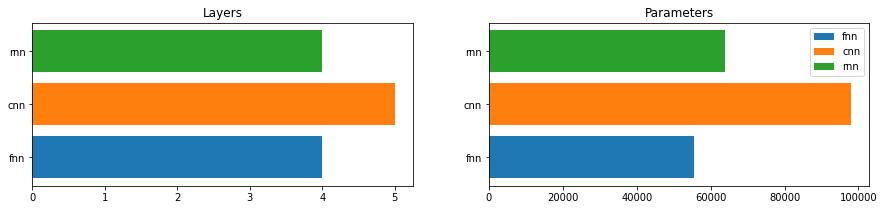

In [18]:
# The model summaries show the number of layers and parameters for each model. 
models = ['fnn', 'cnn', 'rnn']
model_info = ['layers', 'parameters']
syntax = ['len({}.layers)', '.count_params()']

def get_syntax(i, model):
    if i == 0: 
        return len(eval('{}.layers'.format(model)))
    else: 
        return eval(model + '.count_params()')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
for i in range(len(model_info)):
    axes[i].set_title(model_info[i].title())
    axes[i].barh(models[0], get_syntax(i, models[0]), label='fnn')
    axes[i].barh(models[1], get_syntax(i, models[1]), label='cnn')
    axes[i].barh(models[2], get_syntax(i, models[2]), label='rnn')
plt.legend()
plt.show()

### Results table

This cell shows how the cnn and rnn models outperform the fnn model when it comes to accuracy, precision and recall on the validation data.

In [19]:
# prints the average of the last 4 epochs.
def model_summary(model):
    metrics = []
    history = model + '_history.history'
    for i in ['accuracy', 'precision', 'recall']:
        metrics.append(round(sum(eval(history)['val_{}'.format(i)][(epochs-4):epochs])/4,2))
    df = pd.DataFrame() 
    df[model] = metrics
    df.index = ['accuracy', 'precision', 'recall']
    return df

results = pd.DataFrame()

for model in models:
    results[model] = model_summary(model)
    
results

,fnn,cnn,rnn
accuracy,0.87,0.91,0.92
precision,0.81,0.92,0.92
recall,0.46,0.62,0.67


### Results plot

This cell demonstrates how accuracy and precision generally fare better than recall. 

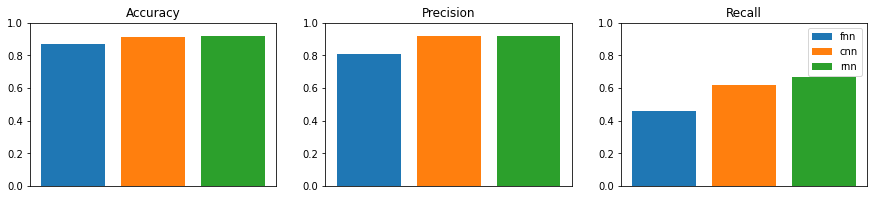

In [20]:
# The summary results show how the cnn and rnn model generally perform better than the ffn model. 
metrics = ['accuracy', 'precision', 'recall']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for i in range(len(metrics)):
    axes[i].set_title(metrics[i].title())
    axes[i].set_ylim(0,1)
    axes[i].get_xaxis().set_visible(False)
    axes[i].bar(models[0], results.loc[:,'fnn'][i], label='fnn')
    axes[i].bar(models[1], results.loc[:,'cnn'][i], label='cnn')
    axes[i].bar(models[2], results.loc[:,'rnn'][i], label='rnn')
plt.legend()
plt.show()

### Validation results by epoch

This cell shows how the best results on the validation data are generally obtained after the 10th epoch.

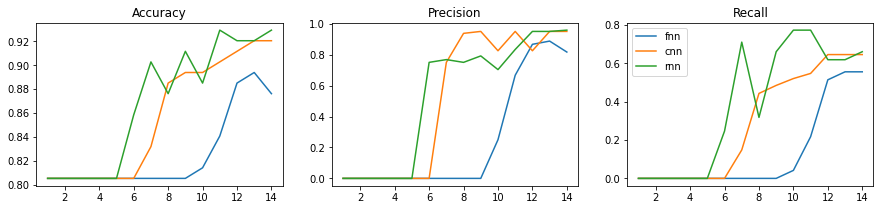

In [21]:
# plots the results for each algorithm on the validation data by epoch. 
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall']

fnn_data = pd.DataFrame()
cnn_data = pd.DataFrame()
rnn_data = pd.DataFrame()

for metric in metrics:
    fnn_data[metric] = fnn_history.history['val_{}'.format(metric)]
    cnn_data[metric] = cnn_history.history['val_{}'.format(metric)]
    rnn_data[metric] = rnn_history.history['val_{}'.format(metric)]
    epochs = range(1, len(fnn_data) + 1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for i in range(len(metrics)):
    axes[i].set_title(metrics[i].title())
    axes[i].plot(epochs, fnn_data[metrics[i]], label='fnn')
    axes[i].plot(epochs, cnn_data[metrics[i]], label='cnn')
    axes[i].plot(epochs, rnn_data[metrics[i]], label='rnn')
plt.legend()
plt.show()

### Training vs validation results

These next few cells visualize the difference across our metrics between the training and validation data.

In [22]:
# defines a fucnction which plots training verses validation data to see if we are over or underfitting. 
def get_train_val(model):
    acc = pd.DataFrame()
    
    for i in metrics:
        acc[i] = eval(model + '_history.history')[i]
        acc['val_'+i] = eval(model + '_history.history')['val_{}'.format(i)]
        
    acc['epoch'] = range(1, len(acc) + 1)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
    for i in range(len(metrics)):
        axes[i].set_title(metrics[i].title())
        axes[i].plot(acc['epoch'], acc[metrics[i]], 'b', label='Training')
        axes[i].plot(acc['epoch'], acc['val_' + metrics[i]], 'r', label='Validation')
    plt.legend()
    plot = plt.show()

### 1. fnn...

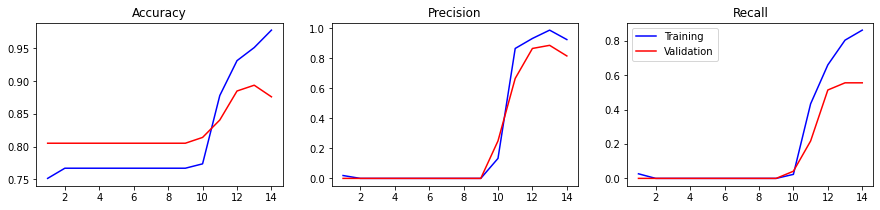

In [23]:
get_train_val('fnn')

### 2. cnn...

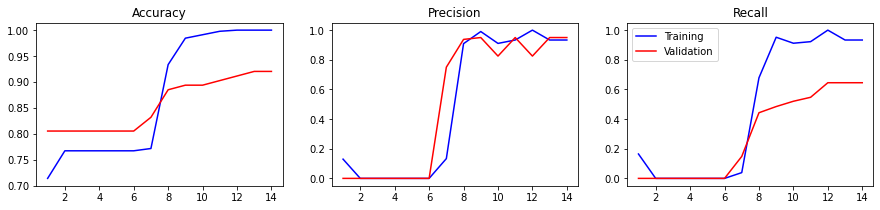

In [24]:
get_train_val('cnn')

### 3. rnn...

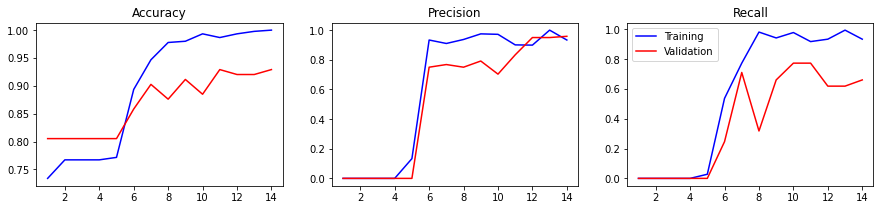

In [25]:
get_train_val('rnn')

### What are we getting wrong?

This cell saves to csv a spread sheet for each of our models listing the headlines they misclassified.

In [26]:
# locates and saves to csv the wrongly predicted headlines for each model. 
models = ['fnn', 'cnn', 'rnn']

for model in models:
    prediction = np.round(eval(model).predict(x_test_seq_padded))
    unlisted_preds = [item for sublist in prediction for item in sublist]
    
    wrong_predictions = unlisted_preds != y_test
    false_predictions = x_test[wrong_predictions]
    
    mis_labeled = df.loc[false_predictions.index,]
    
    mis_labeled.to_csv('C:/Users/HUAWEI/Desktop/Exploratory data/Planet Terror/Data/mis-labeled/{}_mislabeled.csv'.format(model))
    
    print('{}: '.format(model) + str(len(mis_labeled)) + ' mislabelled headlines - ' + str(round(len(mis_labeled)/len(y_test)*100,2)) + '% of the data.')

4/4 [==============================] - 0s 2ms/step
fnn: 14 mislabelled headlines - 12.39% of the data.
4/4 [==============================] - 0s 2ms/step
cnn: 9 mislabelled headlines - 7.96% of the data.
4/4 [==============================] - 0s 3ms/step
rnn: 8 mislabelled headlines - 7.08% of the data.


### Problem headlines

This cell loads in the mislcassified spreadsheets and prints a table of the problematic headlines which were misclassified by at least two of our models.

In [27]:
# views all the headlines which are mislabelled by at least two of our models.
mislabeled_headlines = []

for model in models:
    mislabeled_headlines.append(pd.read_csv('C:/Users/HUAWEI/Desktop/Exploratory data/Planet Terror/Data/mis-labeled/{}_mislabeled.csv'.format(model)))
    
problems = pd.concat(mislabeled_headlines).iloc[:,2:4]

headlines = list(problems.loc[:,'Headline'])
duplicates = [headline for headline in headlines if headlines.count(headline) > 1]
unique_duplicates = list(set(duplicates))

problems.loc[problems.loc[:,'Headline'].isin(unique_duplicates),:].drop_duplicates()

,Headline,Category
0,Mali jihadists claim capture of fighter with Russia's Wagner,terrorism
1,2 PMU forces martyred in ISIL attack on Iraq's Samarra,terrorism
2,Terrorist group kills 2 members of Internal Security Forces in Daraa,terrorism
4,YPG/PKK suicide attack in Syria's Afrin foiled,none
6,"US-backed YPG/PKK terrorists abduct civilians, burn homes in Syria",terrorism
7,"Islamic State claims Nigeria bombing, says about 30 killed or hurt",terrorism
9,Al Shabab says killed six people in Kenyaâs Lamu,terrorism
2,Six Niger troops killed in 'terrorist' attack,terrorism
